In [5]:
import numpy

import tensorflow as tf
import tensorflow_datasets as tfds

import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow import data

print(numpy.__version__)
print(tf.__version__)

1.21.6
2.8.2


In [6]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)
    
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [7]:
data_path = '/content/drive/MyDrive/Data/001CV/cGAN/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


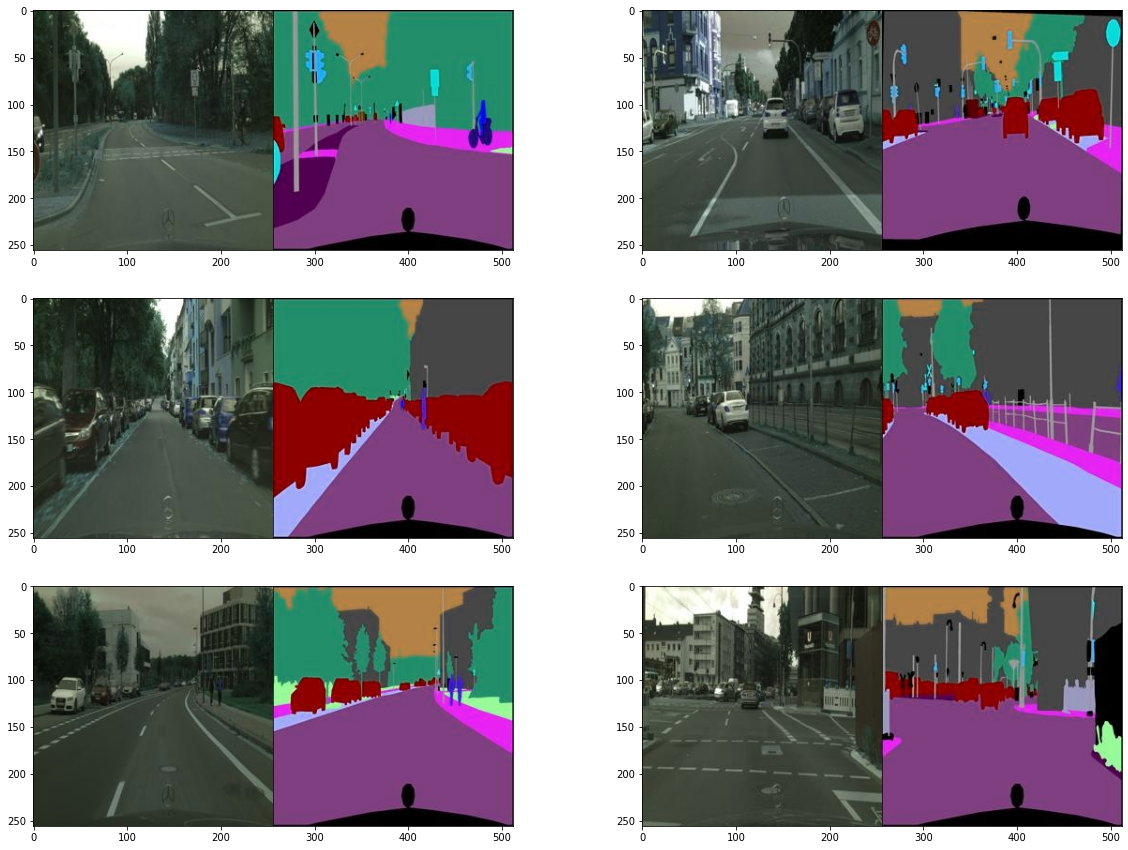

In [8]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [9]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


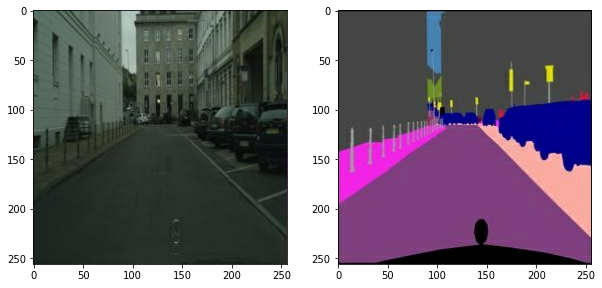

In [10]:
# 이미지 분리
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## Augmentation func

In [11]:
# Augmentation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    #1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
    stacked = tf.concat([sketch, colored], axis=-1)
    
    #2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    
    #3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
    out = image.random_crop(padded, size=[256, 256, 6])
    
    #4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
    out = image.random_flip_left_right(out)
    #5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        #6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

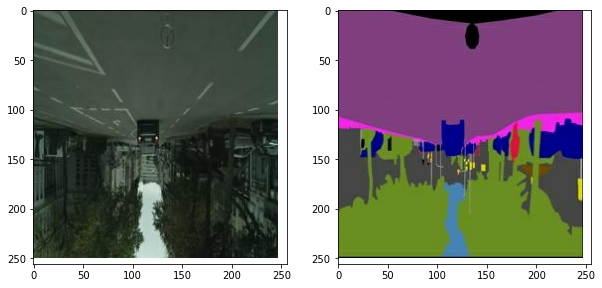

In [47]:
# Augmentation 적용
train_images = data.Dataset.list_files(data_path + "*.jpg")

train_images = train_images.map(get_train).shuffle(1000).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Modeling

## Generator

### Encoder

In [13]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [14]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

### Decoder

In [16]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

### EncoderDecoderGenerator

In [18]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [19]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### U-Net Generator

In [20]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [21]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

## Discriminator

In [23]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [24]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [25]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

## Loss

In [26]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

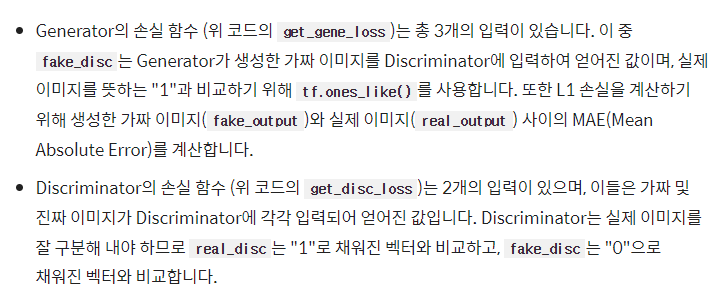

## Optimizer

In [28]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


## Train_step

In [29]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [35]:
#참고: https://github.com/seonghyun97/Aiffel_Exploration/blob/master/%5BE-16%5DColorbook.ipynb

val_data_path ='/content/drive/MyDrive/Data/001CV/cGAN/cityscapes/val/'
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

save_images = []
for path in val_path:
    img, _ = load_img(path)
    save_images.append(img)

save_images = np.array(save_images)

def save_val_img(path):
    predict = generator(save_images)
    predict = denormalize(predict)

    plt.figure(figsize=(4, 4))
    plt.subplots_adjust(wspace=0.05, hspace=0.1)
    for i in range(4):
        plt.subplot(2, 2, 1+i)
        plt.imshow(predict[i])
        plt.axis("off")
    plt.savefig(path)
    plt.clf()

In [48]:
EPOCHS = 800
#참고: https://github.com/seonghyun97/Aiffel_Exploration/blob/master/%5BE-16%5DColorbook.ipynb

generator = UNetGenerator()
discriminator = Discriminator()
gen_loss_list, dis_loss_list, L1_loss_list = [], [], []

for epoch in range(1, EPOCHS+1):
    save_val_img(f"/content/drive/MyDrive/Data/001CV/cGAN/image/{epoch}.png")
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        gen_loss_list.append(g_loss)
        dis_loss_list.append(d_loss)
        L1_loss_list.append(l1_loss)
                

        # 100회 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:5.4282                     
L1_loss:0.0968                     
Discriminator_loss:0.0305

EPOCH[2] - STEP[200]                     
Generator_loss:3.8937                     
L1_loss:0.1221                     
Discriminator_loss:0.0806

EPOCH[3] - STEP[200]                     
Generator_loss:7.6091                     
L1_loss:0.1338                     
Discriminator_loss:0.0052

EPOCH[4] - STEP[200]                     
Generator_loss:6.2144                     
L1_loss:0.1199                     
Discriminator_loss:0.4889

EPOCH[5] - STEP[200]                     
Generator_loss:7.9103                     
L1_loss:0.1211                     
Discriminator_loss:3.0317

EPOCH[6] - STEP[200]                     
Generator_loss:8.3173                     
L1_loss:0.1020                     
Discriminator_loss:2.4323

EPOCH[7] - STEP[200]                     
Generator_loss:7.9042                     
L1_loss:0.1165             

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


EPOCH[21] - STEP[200]                     
Generator_loss:5.6982                     
L1_loss:0.1112                     
Discriminator_loss:0.0366

EPOCH[22] - STEP[200]                     
Generator_loss:5.7254                     
L1_loss:0.0876                     
Discriminator_loss:0.0124

EPOCH[23] - STEP[200]                     
Generator_loss:6.4482                     
L1_loss:0.0947                     
Discriminator_loss:0.4999

EPOCH[24] - STEP[200]                     
Generator_loss:1.3749                     
L1_loss:0.0951                     
Discriminator_loss:0.5843

EPOCH[25] - STEP[200]                     
Generator_loss:0.9630                     
L1_loss:0.0776                     
Discriminator_loss:1.1262

EPOCH[26] - STEP[200]                     
Generator_loss:6.4537                     
L1_loss:0.1075                     
Discriminator_loss:0.0088

EPOCH[27] - STEP[200]                     
Generator_loss:8.2133                     
L1_loss:0.1205      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


EPOCH[790] - STEP[200]                     
Generator_loss:8.6076                     
L1_loss:0.0993                     
Discriminator_loss:0.0649

EPOCH[791] - STEP[200]                     
Generator_loss:9.0290                     
L1_loss:0.1179                     
Discriminator_loss:0.0007

EPOCH[792] - STEP[200]                     
Generator_loss:10.3649                     
L1_loss:0.0846                     
Discriminator_loss:0.2873

EPOCH[793] - STEP[200]                     
Generator_loss:4.4762                     
L1_loss:0.1008                     
Discriminator_loss:0.1080

EPOCH[794] - STEP[200]                     
Generator_loss:6.4243                     
L1_loss:0.1108                     
Discriminator_loss:0.0077

EPOCH[795] - STEP[200]                     
Generator_loss:9.2446                     
L1_loss:0.1020                     
Discriminator_loss:0.0055

EPOCH[796] - STEP[200]                     
Generator_loss:5.0886                     
L1_loss:0.10

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

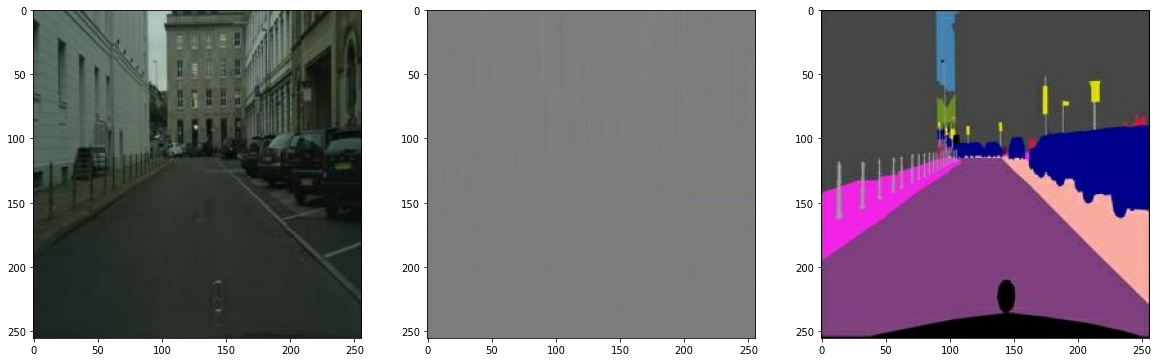

In [51]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

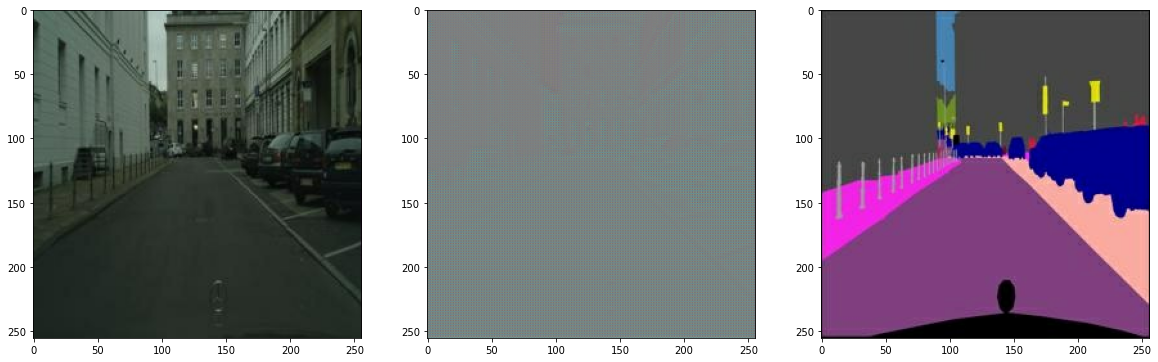

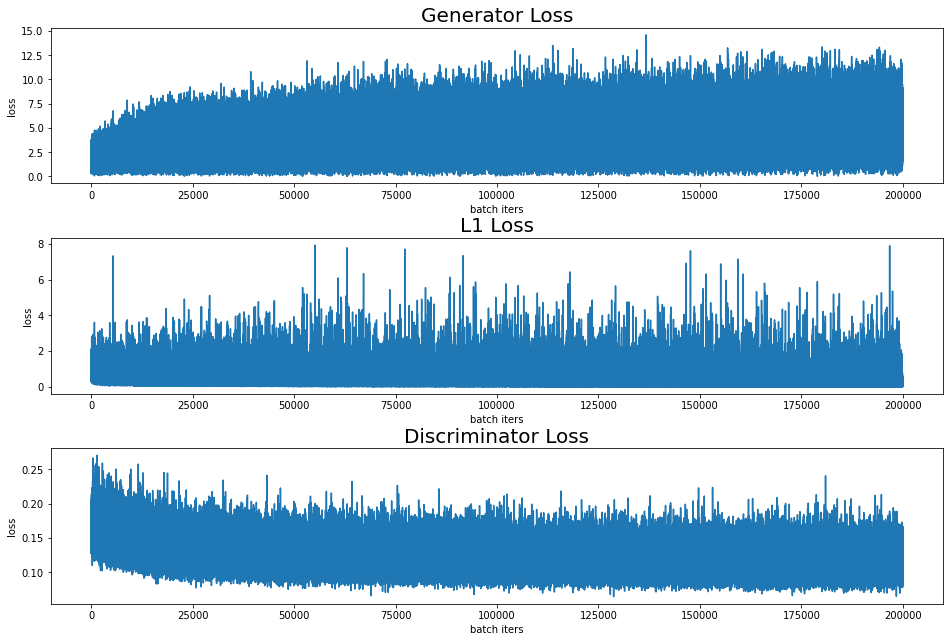

In [38]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

plt.subplot(3, 1, 1)
plt.plot(gen_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Generator Loss', fontsize=20)

plt.subplot(3, 1, 2) 
plt.plot(dis_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('L1 Loss', fontsize=20)

plt.subplot(3, 1, 3)
plt.plot(L1_loss_list)
plt.ylabel('loss')  
plt.xlabel('batch iters')  
plt.title('Discriminator Loss', fontsize=20)

plt.show()

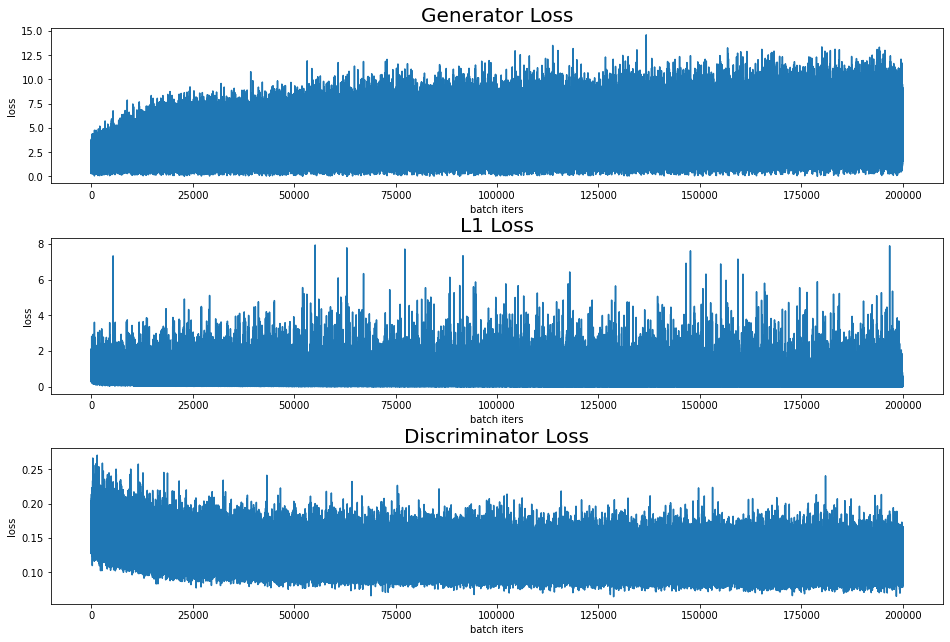

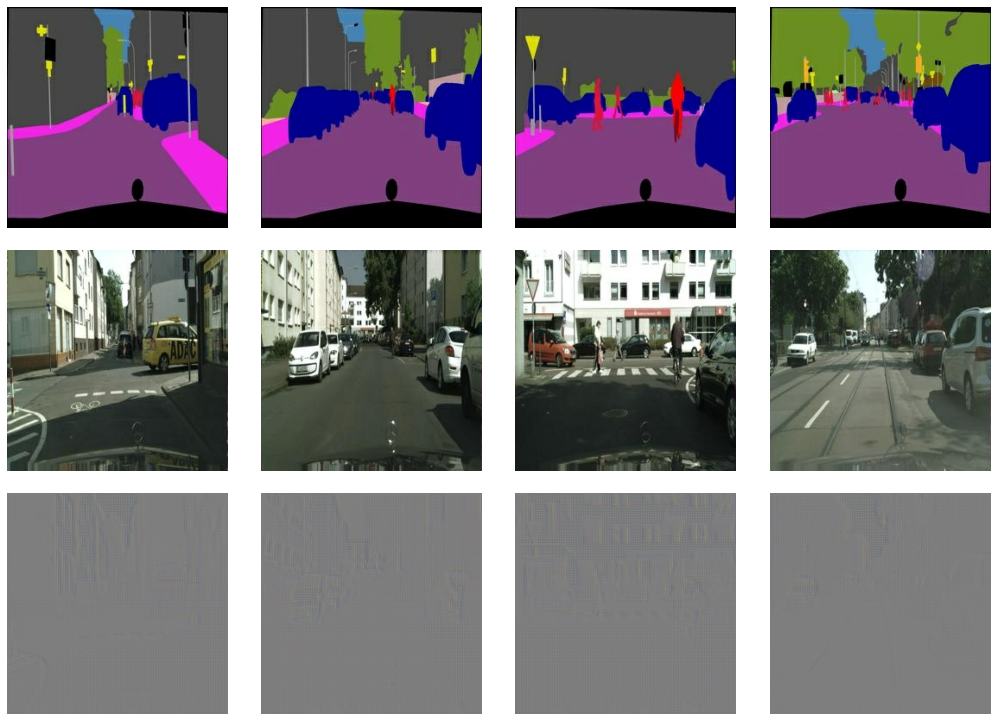

In [53]:
val_path = [val_data_path + path for path in os.listdir(val_data_path)]

seg_images, real_images = [], []
for path in val_path:
    seg_img, real_img = load_img(path)
    seg_images.append(seg_img)
    real_images.append(real_img)

seg_images = np.array(seg_images)

real_images = np.array(real_images)
real_images = (real_images + 1) * 127.5
real_images = real_images.astype(np.uint8)

predict = generator(seg_images)
predict = denormalize(predict)

seg_images = (seg_images + 1) * 127.5
seg_images = seg_images.astype(np.uint8)

plt.figure(figsize=(18, 13))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
for i in range(4):
    plt.subplot(3, 4, i + 1)
    plt.imshow(real_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 5)
    plt.imshow(seg_images[i])
    plt.axis("off")
    
    plt.subplot(3, 4, i + 9)
    plt.imshow(predict[i])
    plt.axis("off")

In [54]:
import imageio
epoch_nums = [int(path.replace(".png", "")) for path in os.listdir("/content/drive/MyDrive/Data/001CV/cGAN/image/")]
epoch_nums.sort()

img_path_list = [f"/content/drive/MyDrive/Data/001CV/cGAN/image/{epoch}.png" for epoch in epoch_nums]
img_list = [cv2.imread(img_path) for img_path in img_path_list]

imageio.mimsave("/content/drive/MyDrive/Data/001CV/cGAN/image/frame.gif", img_list)

# 회고

800 epoch 이나 학습을 시켜보았지만 결과가 정말 좋지 않다.

단 하나도 원본을 반영하지 않았다.

이래서야 더 많이 학습시킨다 해도 결과가 좋을 것 같지 않다.

생성모델에서 뭔가 잘못된것 같다.